In [24]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.restoration import estimate_sigma
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.exposure import rescale_intensity
import pywt

base_path = "../CBIS-DDSM_Clean_Data/"
train = pd.read_csv(base_path + "train_full.csv")

In [25]:
image_path = os.path.join("../",(train["image_path"].iloc[0]))
image_path

'../CBIS-DDSM_Clean_Data/labeled_images_png/1.3.6.1.4.1.9590.100.1.2.100131208110604806117271735422083351547_full.png'

# Background Removal Using Otsu Segemntation, Morphological Closing

In [26]:
def background_removal(image):

    # resize to remove a contour of the whole image to remove some of the marks of x-rays that are not the breast
    height, width = image.shape[:2]
    image = image[45:height-45, 45:width-45]

    # smooth image
    blur_img = cv2.GaussianBlur(image, (5,5), 0)

    # gets Otsu threshold 
    _, thresh = cv2.threshold(blur_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

    # apply morphological closing to make sure parts of the breast are not removed 
    kernel = np.ones((15, 15), np.uint8) 
    closed_img = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Identify connecting regions for each pixel edge and corner (8) of binary image 
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closed_img, connectivity=8)

    # find the largest component that is connected
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    
    # generate mask of black background
    mask = (labels == largest_label).astype(np.uint8) * 255
    breast_img = cv2.bitwise_and(image, image, mask=mask)
    
    
    
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,4,1)
    plt.title("Original")
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.title("Closed")
    plt.imshow(closed_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,4,3)
    plt.title("Otsu Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.title("Cleaned Breast")
    plt.imshow(breast_img, cmap='gray')
    plt.axis('off')
    
    plt.show()
    return breast_img, mask

In [27]:
images = {}
images["original"] = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


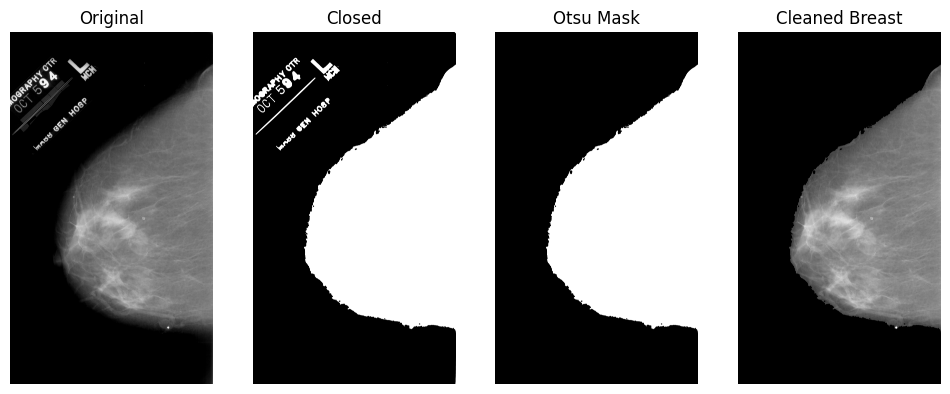

In [28]:
breast_img, mask = background_removal(images["original"])

# Crop and Resizing Using Countours

In [29]:
def crop(image, breast_mask):
    
    # find contours of breast image using the mask. 
    # - RETR_EXTERNAL: defines only external countour of the biggest section, 
    # - CHAIN_APPROX_SIMPLE: saves only non redundant and the simplest points of the countour 
    # source: https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18
    contours, _ = cv2.findContours(breast_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # checks for non-countour
    if len(contours) == 0:
        return image

    # find the countour area
    # source: https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
    area = max(contours, key=cv2.contourArea)
    
    # find the bounding box
    x, y, w, h = cv2.boundingRect(area)

    # crops image using bounding box
    cropped = image[y:y+h, x:x+w]

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("No Background")
    plt.imshow(breast_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.title("Cropped")
    plt.imshow(cropped, cmap='gray')
    plt.axis('off')

    plt.show()
    
    return cropped

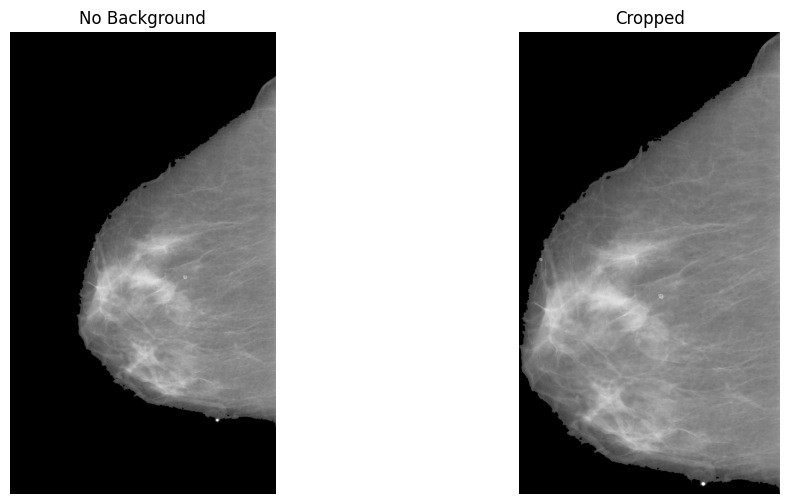

In [30]:
cropped = crop(breast_img, mask)

# Noise removal using Gaussian Blur and Wavelet Transform Soft Threshold

In [31]:
# Noise removal function using simple Gaussian Blur
def noise_reduction_GB(image):
    '''Denoise image using the parameters:
        - image 
        - kernel
        - sigma value for denoising
    '''
    return cv2.GaussianBlur(image, (5,5), 0)

In [32]:
# Noise removal using Wavelet Soft Denoiser 
def noise_reduction_WT(image):
    '''Denoise image by: 
       - calculating coefficients of approximation and detail
       - calculating sigma value
       - calculating and applying soft thresholding value to coefficients 
       - and reconstructing image using coefficinets'''
    
    # Calculate coefficients for the image using wavedec2 for 2D (image) decomposition 
    # using the  Daubechies wavelet db1 (Haar wavelet of interval of 0-1)  
    init_coeffs = pywt.wavedec2(image, wavelet="db1", level=2)

    # calculate sigma of the detail coefficients
    sigma = estimate_sigma(image, channel_axis=None)

    # calculate initial threshold
    init_threshold = sigma * np.sqrt(2 * np.log2(image.size))

    # iterate through detail coefficients to apply threshhold function using the initial threshold
    new_coeffs = [init_coeffs[0]]

    for level in init_coeffs[1:]:
        tuple_vals = tuple(pywt.threshold(detail, init_threshold, mode='soft') for detail in level)
        new_coeffs.append(tuple_vals)

    # Reconstruct image using waverec2
    denoised_img = pywt.waverec2(new_coeffs, wavelet="db1")
    reconstructed = denoised_img[:image.shape[0], :image.shape[1]]
    
    return reconstructed
    

    

In [33]:
denoised_GB = noise_reduction_GB(cropped)
denoised_WT = noise_reduction_WT(cropped)

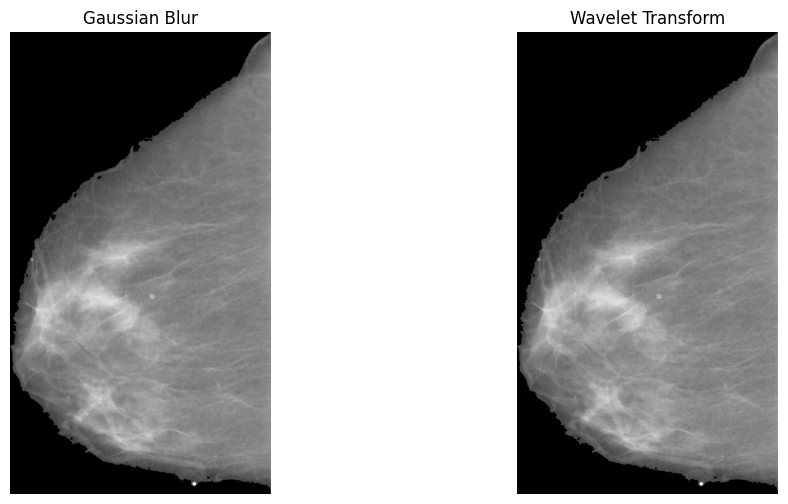

In [34]:
# plot denoised images using Gaussian Blur from cv2 and Wavelets from pywt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Gaussian Blur")
plt.imshow(denoised_GB, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Wavelet Transform")
plt.imshow(denoised_WT, cmap='gray')
plt.axis('off')

plt.show()

/tmp/ipykernel_2223/507999137.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value_WT = psnr(cropped, denoised_WT)


46.13852334622428
46.08353638419814


(np.float64(-0.5), np.float64(2800.5), np.float64(4961.5), np.float64(-0.5))

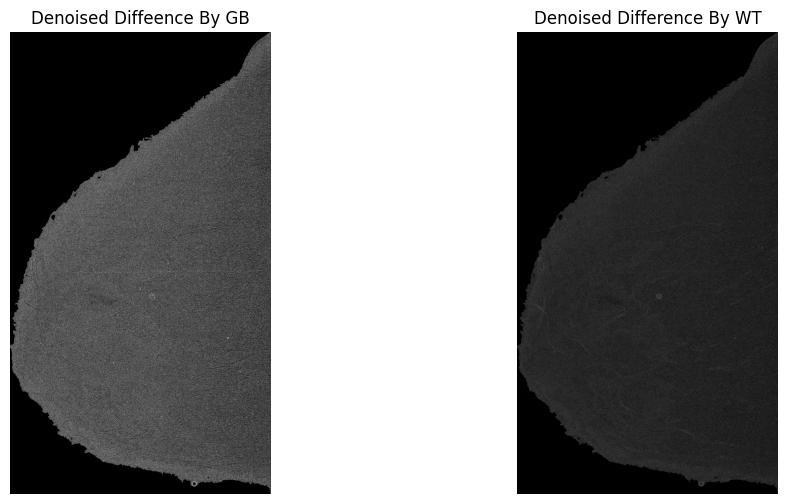

In [35]:
# calculate peak signal noise ratio (PSNR)  
psnr_value_GB = psnr(cropped, denoised_GB)
psnr_value_WT = psnr(cropped, denoised_WT)

print(psnr_value_GB)
print(psnr_value_WT)

# calculate the difference between original and denoised images
diff_GB = np.abs(cropped - denoised_GB)
diff_WT = np.abs(cropped - denoised_WT)

# rescale image intensity to visualize
diff_GB_vis = rescale_intensity(diff_GB, in_range='image', out_range=(0,1))
diff_WT_vis = rescale_intensity(diff_WT, in_range='image', out_range=(0,1))

# plot the difference between original and denoised images
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Denoised Diffeence By GB")
plt.imshow(diff_GB_vis, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Denoised Difference By WT")
plt.imshow(diff_WT_vis, cmap='gray')
plt.axis('off')

# Contrast Enhancement using CLAHE

In [36]:
def contrast_enhancement(image):
    # code provenance 
    # https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html

    # verify the image is in gray scale
    if len(image.shape) == 3:  # If color image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # verify image is intiger type 
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = image.astype(np.uint8)

    # initialize CLAHE and apply to image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clh_image = clahe.apply(image)

    # create a histogram of the CLAHE image 
    hist_clahe, bins_clahe = np.histogram(image.flatten(),256,[0,256])
    
    cdf_clahe = hist_clahe.cumsum()
    cdf_normalized_clahe = cdf_clahe * float(hist_clahe.max()) / cdf_clahe.max()

    # create a histogram of the previously preprocessed image 
    hist, bins = np.histogram(image.flatten(),256,[0,256])
    
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    plt.figure(figsize=(12,6))
    plt.subplot(2,2,1)
    plt.title("Preprocessed")
    plt.imshow(image, cmap= "gray")
    plt.subplot(2,2,2)
    plt.title("Flatten Image Histogram")
    plt.plot(cdf_normalized, color = 'b')
    plt.hist(image.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')

    plt.subplot(2,2,3)
    plt.title("CLAHE")
    plt.imshow(clh_image, cmap= "gray")
    plt.subplot(2,2,4)
    plt.title("CLAHE Histogram")
    plt.plot(cdf_normalized_clahe, color = 'b')
    plt.hist(clh_image.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')

    
    plt.show()
    
    return clh_image

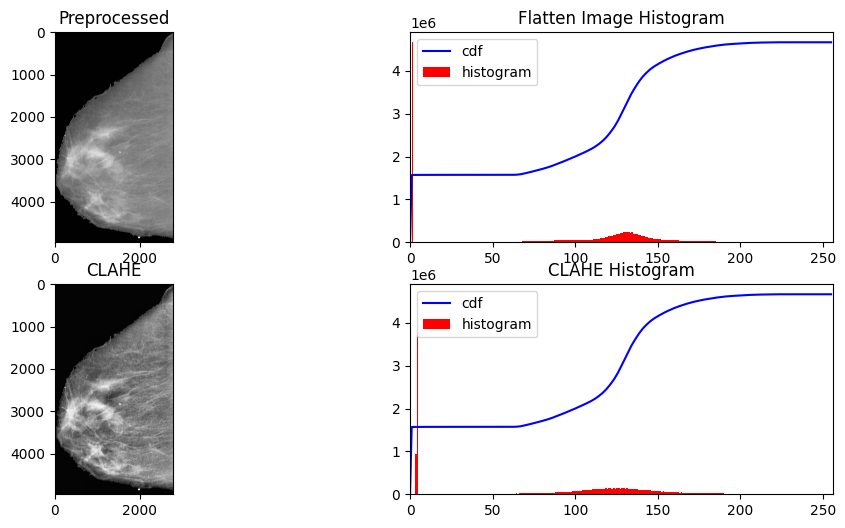

In [37]:
contrast_enhanced = contrast_enhancement(denoised_WT)

# Edge Enhancement using Counterlet Transformation

In [38]:
def edge_enhancement(guide_image, input_image, radius=8, epsilon = 0.0001):    

    '''Use guided filter to smooth image and keep edges sharp. Uses input image to be filter and as guide for pixel smoothness.
        - guided image
        - input image
        - kernel radius
        - regularization value
    '''

    # Normalize values
    guide_image = guide_image.astype(np.float32) / 255.0
    input_image = input_image.astype(np.float32) / 255.0
    
    # compute local mean: guidance and input image
    mean_guide = cv2.boxFilter(guide_image, -1, (radius, radius)) # depth is -1 for source depth
    mean_input = cv2.boxFilter(input_image, -1, (radius, radius)) # depth is -1 for source depth
    mean_g_i = cv2.boxFilter(guide_image * input_image, -1, (radius, radius)) # mean of product of both images
    mean_g_g = cv2.boxFilter(guide_image * guide_image, -1, (radius, radius))# compute loacl mean of product of guide image
    
    # calculate variance 
    covar_g_i = mean_g_i - mean_guide * mean_input # of the product of loacl means of both images  against local mean of the product of both images
    var_g = mean_g_g - mean_guide * mean_guide # of guidance image 

    # calculate coefficinets using means , covariance and variance
    alpha = covar_g_i / (var_g + epsilon)
    beta = mean_input - alpha * mean_guide

    # calculate mean of coefficinets
    mean_alpha = cv2.boxFilter(alpha, -1, (radius, radius))
    mean_beta = cv2.boxFilter(beta, -1, (radius, radius))

    # apply mean of alpha to the guide image and add mean of beta
    filtered = mean_alpha * guide_image + mean_beta

    # convert back to intigers
    filtered = (filtered * 255).astype(np.uint8)

    return filtered

In [39]:
edge_enhanced = edge_enhancement(contrast_enhanced, contrast_enhanced)